# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [3]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
#import sstats.sigp_AP as sigp_AP
from sstats import get_cmap_colors
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [1]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=2)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.205:8787/status,
Dashboard: http://10.148.0.205:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.205:57866,Workers: 0
Dashboard: http://10.148.0.205:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [3]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



In [6]:
dt = 1/24 # time step in days

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)
#print('omega (M2+S2)/2:%s'%(omega_M2+omega_S2)/2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [7]:
dband = [0.1,0.2,0.3] #0.05,
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


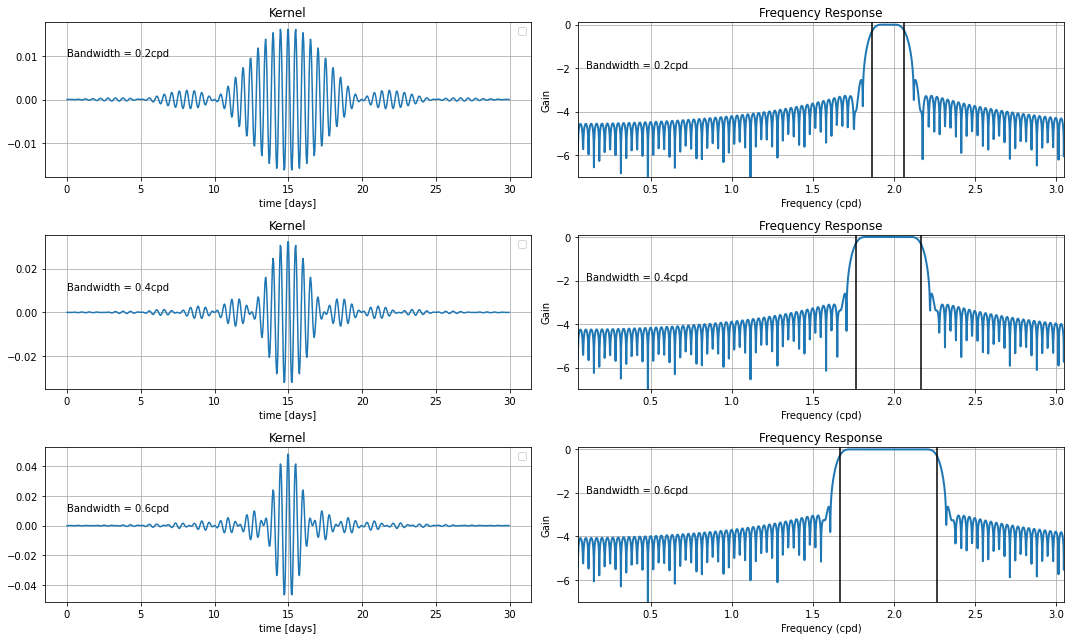

In [8]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(len(h.keys()),2, figsize=(15,3*len(h.keys())))
for i, k in enumerate(h.keys()):
    ax = axes[i,0]
    ax.plot(t, h[k])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()
    ax.text(0,0.01,'Bandwidth = %scpd'%(2*float(k)))
    ax = axes[i,1]

    ax.plot(w[k], np.log10(abs(h_hat[k])), linewidth=2)
    ax.axvline(omega-float(k), color='k')
    ax.axvline(omega+float(k), color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)
    ax.text(0.1,-2,'Bandwidth = %scpd'%(2*float(k)))
    
fig.tight_layout()

In [9]:
t_size=300
T,T_low = [5,30,80],[5,15,30]
U_high = [0.1]#[0.01,0.05,0.1,1.]
nb_draws = 500

### Generation signal: 

In [10]:
# Incoherent part

U = 0.1 # true variance

# generate time series
u = {}
i = 0
for c in ['M2','S2']:
    for part in ['real','imag']:
        i += 1
        u[c+'_'+part] = ts.exp_autocorr((t_size, dt), T, 
                                 U/np.sqrt(2), 
                                 #burnin=int(10*T/dt),
                                 draws=nb_draws, chunks={'draws':-1,'T':-1},
                                 seed=i,name=c+'_'+part+'_inc'
                                ).persist()


In [11]:
u['M2'] = u['M2_real']+1j*u['M2_imag']
u['S2'] = u['S2_real']+1j*u['S2_imag']

In [12]:
exp_M2 = np.exp(1j*omega_M2*rad*u['M2'].time)
exp_S2 = np.exp(1j*omega_S2*rad*u['M2'].time)

In [13]:
u_M2_inc = u['M2']*exp_M2
u_M2_coh = U*exp_M2
u_M2_mix = u_M2_inc/np.sqrt(2)+u_M2_coh/np.sqrt(2)

u_S2_inc = u['S2']*exp_S2
u_S2_coh = U*exp_S2
u_S2_mix = u_S2_inc/np.sqrt(2)+u_S2_coh/np.sqrt(2)

In [14]:
high_MS_mix = u_M2_mix+u_S2_mix
high_MS_coh = u_M2_coh+u_S2_coh

high_MS_inc = u_M2_inc+u_S2_inc

In [15]:
ds = xr.Dataset({'M2_coh':u_M2_coh,'S2_coh':u_S2_coh,'high_MS_coh':high_MS_coh.rename('u_high'),
                'M2_mix':u_M2_mix,'S2_mix':u_S2_mix,'high_MS_mix':high_MS_mix.rename('u_high'),
                'M2_inc':u_M2_inc,'S2_inc':u_S2_inc,'high_MS_inc':high_MS_inc.rename('u_high')
                })
ds = ds.persist()

In [16]:
for c,om in zip(['M2','S2','high_MS'],[omega_M2,omega_S2,omega]):
    
    for p in ['coh','mix','inc']:
        exp = np.exp(-1j*om*rad*ds[c+'_'+p].time)
        if p=='coh':
#            ds[c+'_'+p+'_complex'] = xr.DataArray(signal.hilbert(ds[c+'_'+p].real,axis=0),dims=["time"])
            ds[c+'_'+p+'_demodulated'] = ds[c+'_'+p]*exp
        else:
#            ds[c+'_'+p+'_complex'] = xr.DataArray(signal.hilbert(ds[c+'_'+p].real,axis=0),dims=["time","draw"])
            ds[c+'_'+p+'_demodulated'] = ds[c+'_'+p]*exp
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:                  (time: 7200, T: 3, draw: 500)
Coordinates:
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
  * T                        (T) int64 5 30 80
  * draw                     (draw) int64 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables: (12/18)
    M2_coh                   (time) complex128 (0.1+0j) ... (-0.0803168680159...
    S2_coh                   (time) complex128 (0.1+0j) ... (0.08660254037841...
    high_MS_coh              (time) complex128 (0.2+0j) ... (0.00628567236244...
    M2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_mix              (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    ...                       ...
    S2_coh_demodulated       (time) complex128 (0.1+0j) ... (0.1+6.9388939039...
    S2_mix_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_inc_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_coh_demodulated  (time) complex128 (0.2+0j) ... (0.10975530623988...
    high_MS_mix_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_inc_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>

In [17]:
ds_mean = ds.mean('draw').persist()

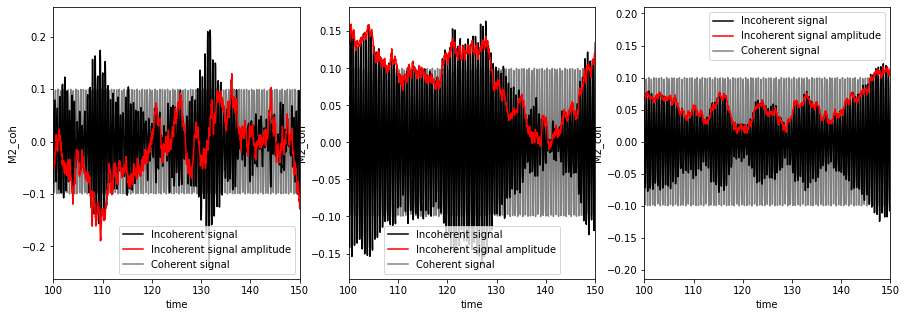

In [18]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

ds.M2_inc.real.sel(draw=0,T=5).plot(ax=axs[0],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=5
                              ).plot(ax=axs[0],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[0],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[0].legend()

ds.M2_inc.real.sel(draw=0,T=30).plot(ax=axs[1],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=30
                              ).plot(ax=axs[1],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[1],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[1].legend()

ds.M2_inc.real.sel(draw=0,T=80).plot(ax=axs[2],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=80
                              ).plot(ax=axs[2],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[2],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[2].legend()


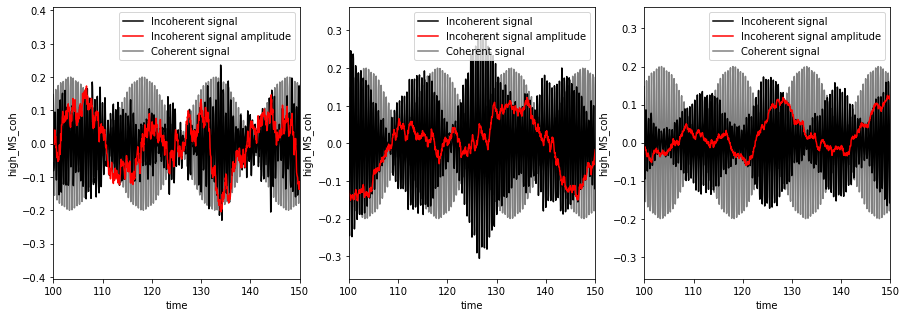

In [19]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

ds.high_MS_inc.real.sel(draw=0,T=5).plot(ax=axs[0],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=5
                              ).plot(ax=axs[0],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[0],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[0].legend()

ds.high_MS_inc.real.sel(draw=0,T=30).plot(ax=axs[1],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=30
                              ).plot(ax=axs[1],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[1],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[1].legend()

ds.high_MS_inc.real.sel(draw=0,T=80).plot(ax=axs[2],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=80
                              ).plot(ax=axs[2],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[2],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[2].legend()

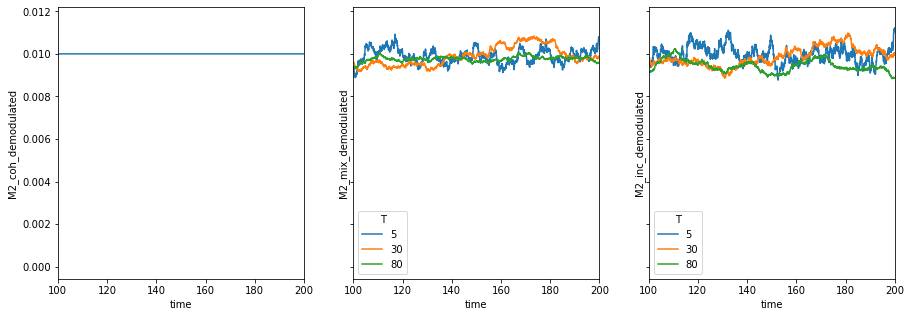

In [20]:
delta_T = 200
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
c = 'M2_coh'
#ds[c+'_demodulated'].real.plot(ax=axs[0],xlim=(0,delta_T))
#ds[c+'_demodulated'].imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
    
for ax,c in zip(axs[1:],['M2_mix','M2_inc']):
#    ds[c+'_demodulated'].mean('draw').real.plot(ax=ax,xlim=(0,delta_T),hue='T')
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=80).plot(ax=ax,xlim=(0,delta_T))
    (np.abs(ds[c+'_demodulated'])**2).mean('draw').plot(ax=ax,xlim=(100,delta_T),hue='T') #,hue='T'

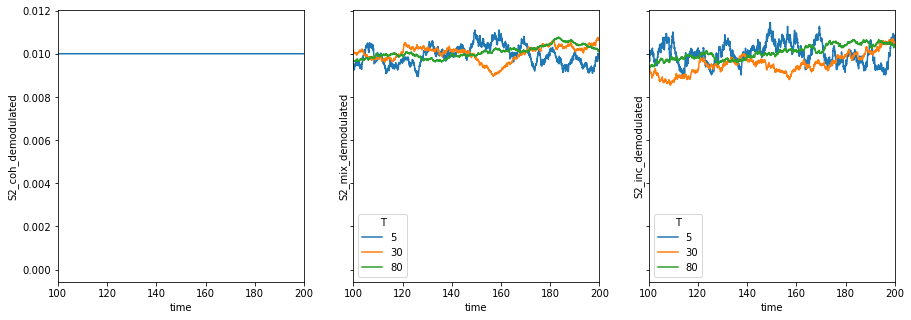

In [21]:
delta_T = 200
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
c = 'S2_coh'
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
    
for ax,c in zip(axs[1:],['S2_mix','S2_inc']):
    (np.abs(ds[c+'_demodulated'])**2).mean('draw').plot(ax=ax,xlim=(100,delta_T),hue='T') #,hue='T'

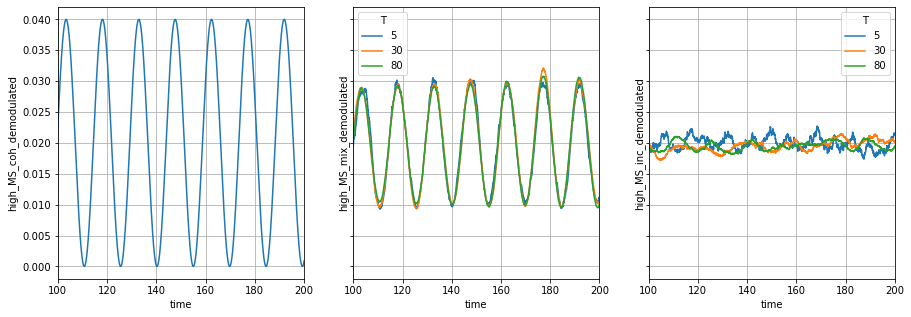

In [22]:
delta_T = 200
fig,axes = plt.subplots(1,3,figsize=(15,5),sharey=True)
axs = axes[:]
c = 'high_MS_coh'
#ds[c+'_demodulated'].real.plot(ax=axs[0],xlim=(0,delta_T))
#ds[c+'_demodulated'].imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
axs[0].grid()
for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):

    (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=[5,30,80]).plot(ax=ax,xlim=(100,delta_T),hue='T')
    ax.grid()
#axs = axes[1,:]
#for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):
#    ds[c+'_demodulated'].real.mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
#    (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
    
#axs = axes[2,:]
#for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):
#    ds[c+'_demodulated'].real.mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))
#   (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))

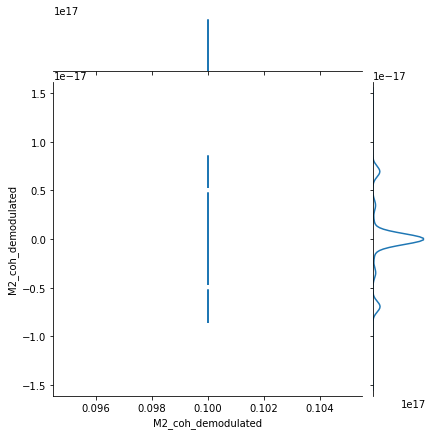

In [23]:
import seaborn as sns
sns.jointplot(x=ds.M2_coh_demodulated.real,y = ds.M2_coh_demodulated.imag,kind='kde')

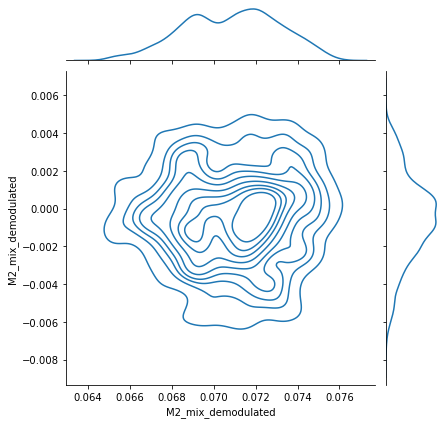

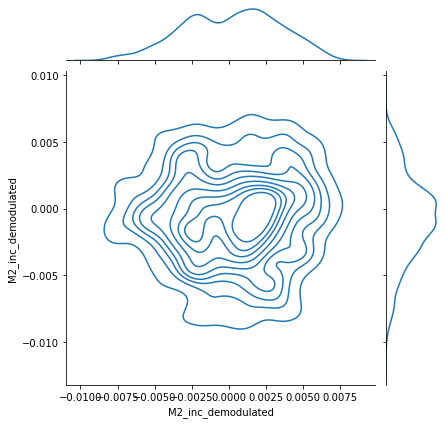

In [24]:
sns.jointplot(x=ds_mean.M2_mix_demodulated.sel(T=5).real,
              y = ds_mean.M2_mix_demodulated.sel(T=5).imag,kind='kde')
sns.jointplot(x=ds_mean.M2_inc_demodulated.sel(T=5).real,
              y = ds_mean.M2_inc_demodulated.sel(T=5).imag,kind='kde')
#sns.jointplot(x=ds.M2_mix_demodulated.sel(T=30).mean('draw').real,
#              y = ds.M2_mix_demodulated.sel(T=30).imag,kind='kde')
#sns.jointplot(x=ds.M2_mix_demodulated.sel(T=80).mean('draw').real,
#              y = ds.M2_mix_demodulated.sel(T=80).imag,kind='kde')

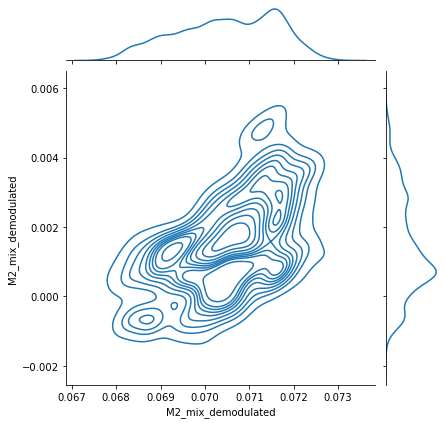

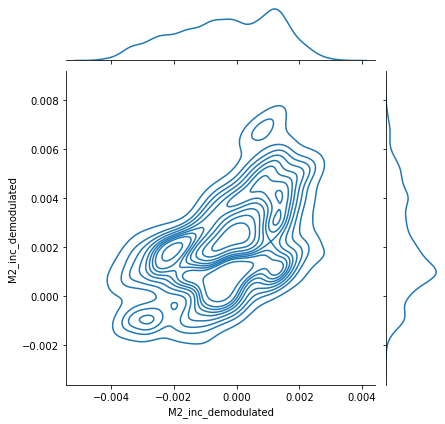

In [25]:
sns.jointplot(x=ds_mean.M2_mix_demodulated.sel(T=80).real,
              y = ds_mean.M2_mix_demodulated.sel(T=80).imag,kind='kde')

sns.jointplot(x=ds_mean.M2_inc_demodulated.sel(T=80).real,
              y = ds_mean.M2_inc_demodulated.sel(T=80).imag,kind='kde')

In [26]:
u_low = hf.low_frequency_signal()
p = dict(U=1.)

low = u_low.generate_tseries(params=p, seed=10,T=T_low,time=(t_size,1/24),draws=nb_draws
                            ).rename('low_signal').persist()
low = low.rename({'T':'T_low'})

In [27]:
ds['low'] = low
ds = ds.persist()

In [28]:
ds['total_coh'] = ds['high_MS_coh']+ds['low']
ds['total_mix'] = ds['high_MS_mix']+ds['low']
ds['total_inc'] = ds['high_MS_inc']+ds['low']
ds = ds.persist()

In [29]:
ds_mean = ds.mean('draw').persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
import sstats.sigp_AP as sigp_AP
ds_filtered = {}
for c,om in zip(['M2','S2','high_MS','total'],[omega_M2,omega_S2,omega,omega]):
    for p in ['_coh','_mix','_inc']:
        ds_filtered[c+p] = xr.concat([sigp_AP.bpass_demodulate(ds[c+p].real, om, dband, 30)[0] for dband in [0.1,0.2,0.3]],dim='bandwidth'
                              ).assign_coords({'bandwidth':[0.2,0.4,0.6]})

In [33]:
ds_filtered.keys()

dict_keys(['M2_coh', 'M2_mix', 'M2_inc', 'S2_coh', 'S2_mix', 'S2_inc', 'high_MS_coh', 'high_MS_mix', 'high_MS_inc', 'total_coh', 'total_mix', 'total_inc'])

In [40]:
ds_filt = xr.merge([ds_filtered[k].rename({'bpassed':k+'_bpassed','demodulated':k+'_demodulated','exp':k+'_exp'}) for k in ds_filtered.keys()])

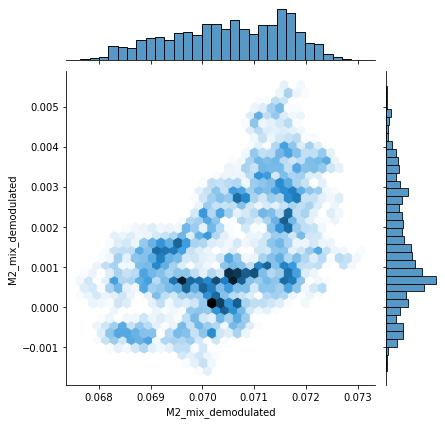

In [44]:
sns.jointplot(x = ds['M2_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

In [47]:
ds_filt_mean = ds_filt.mean('draw').persist()
ds_filt_mean

<xarray.Dataset>
Dimensions:                  (time: 7200, bandwidth: 3, T: 3, T_low: 3)
Coordinates: (12/22)
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
    M2_coh_bpassed           (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_demodulated       (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
  * bandwidth                (bandwidth) float64 0.2 0.4 0.6
  * T                        (T) int64 5 30 80
    ...                       ...
    high_MS_mix_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_inc_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
  * T_low                    (T_low) int64 5 15 30
    total_coh_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_mix_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_inc_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
Data variables:
    M2_coh                   (bandwidth, time) float64 0.1 0.08748 ... -0.08032
    M2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    M2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_coh                   (bandwidth, time) float64 0.1 0.0866 ... 0.0866
    S2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_coh              (bandwidth, time) float64 0.2 0.1741 ... 0.006286
    high_MS_mix              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_inc              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    total_coh                (bandwidth, time, T_low) float64 dask.array<chunksize=(1, 7200, 3), meta=np.ndarray>
    total_mix                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>
    total_inc                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>

In [53]:
ds_filt_mean['M2_coh'].real

<xarray.DataArray 'M2_coh' (bandwidth: 3, time: 7200)>
array([[ 0.1       ,  0.08747542,  0.05303897, ..., -0.09310433,
        -0.09912567, -0.08031687],
       [ 0.1       ,  0.08747542,  0.05303897, ..., -0.09310433,
        -0.09912567, -0.08031687],
       [ 0.1       ,  0.08747542,  0.05303897, ..., -0.09310433,
        -0.09912567, -0.08031687]])
Coordinates:
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
    M2_coh_bpassed           (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_demodulated       (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
  * bandwidth                (bandwidth) float64 0.2 0.4 0.6
    M2_mix_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
    M2_inc_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
    S2_coh_bpassed           (bandwidth, time) complex128 (7.068738878185994e...
    S2_coh_demodulated       (bandwidth, time) complex128 (7.068738878185994e...
    S2_coh_exp               (time) complex128 (1+0j) ... (0.8660254037841576...
    S2_mix_exp               (time) complex128 (1+0j) ... (0.8660254037841576...
    S2_inc_exp               (time) complex128 (1+0j) ... (0.8660254037841576...
    high_MS_coh_bpassed      (bandwidth, time) complex128 (1.5093670905722927...
    high_MS_coh_demodulated  (bandwidth, time) complex128 (1.5093670905722927...
    high_MS_coh_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_mix_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_inc_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    total_coh_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_mix_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_inc_exp            (time) complex128 (1+0j) ... (0.0572698722072138...

TypeError: illegal primitive data type, must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got complex128

In [54]:
import seaborn as sns
sns.jointplot(x = ds['M2_coh_demodulated'].real,
              y=ds['M2_coh_demodulated'].imag,kind="hex")

sns.jointplot(x = ds['M2_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds['M2_inc_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_inc_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4),
              y=ds_filtered['M2_coh'].demodulated.imag.sel(bandwidth=0.4),kind="hex")

sns.jointplot(x = ds_filtered['M2_mix'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['M2_mix'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['M2_inc'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['M2_inc'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2aabbf0631f0> (for post_execute):


KeyboardInterrupt: 

In [76]:
_ds = ds_mean.copy()

for c in ['M2','S2','high_MS']:
    for p in ['_coh','_mix','_inc']:
        _ds[c+p+'_demodulated_real'] = _ds[c+p+'_demodulated'].real
        _ds[c+p+'_demodulated_imag'] = _ds[c+p+'_demodulated'].imag
        _ds[c+p+'_demod_filt_real'] = ds_filtered[c+p].demodulated.real#.mean('draw')
        _ds[c+p+'_demod_filt_imag'] = ds_filtered[c+p].demodulated.imag#.mean('draw')
        _ds = _ds.drop(c+p)
        _ds = _ds.drop(c+p+'_demodulated')
for p in ['_coh','_mix','_inc']:        
    _ds['total'+p+'_demod_filt_real'] = ds_filtered['total'+p].demodulated.real#.mean('draw')
    _ds['total'+p+'_demod_filt_imag'] = ds_filtered['total'+p].demodulated.imag#.mean('draw')
    _ds = _ds.drop('total'+p)


In [79]:
_ds = _ds.drop(['bpassed','demodulated','exp'])

In [80]:
_ds.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_mean.nc')

In [68]:
ds_filt_mean

<xarray.Dataset>
Dimensions:                  (time: 7200, bandwidth: 3, T: 3, T_low: 3)
Coordinates: (12/22)
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
    M2_coh_bpassed           (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_demodulated       (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
  * bandwidth                (bandwidth) float64 0.2 0.4 0.6
  * T                        (T) int64 5 30 80
    ...                       ...
    high_MS_mix_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_inc_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
  * T_low                    (T_low) int64 5 15 30
    total_coh_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_mix_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_inc_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
Data variables:
    M2_coh                   (bandwidth, time) float64 0.1 0.08748 ... -0.08032
    M2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    M2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_coh                   (bandwidth, time) float64 0.1 0.0866 ... 0.0866
    S2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_coh              (bandwidth, time) float64 0.2 0.1741 ... 0.006286
    high_MS_mix              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_inc              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    total_coh                (bandwidth, time, T_low) float64 dask.array<chunksize=(1, 7200, 3), meta=np.ndarray>
    total_mix                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>
    total_inc                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>

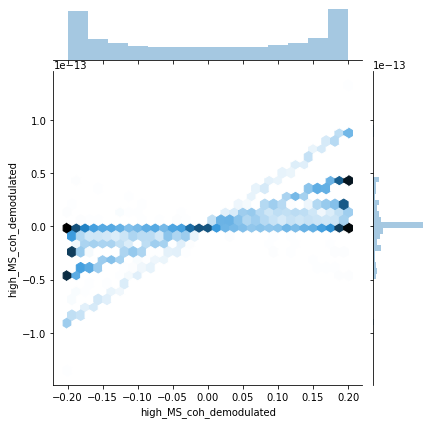

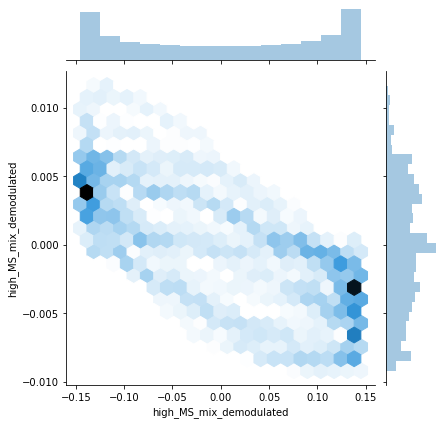

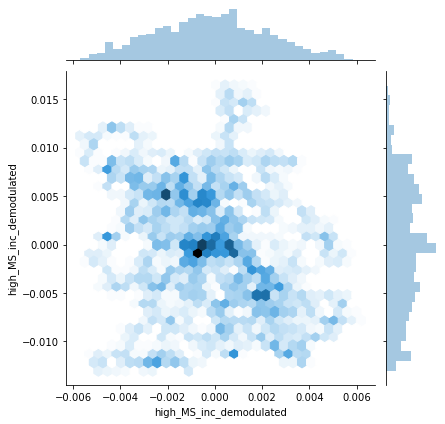

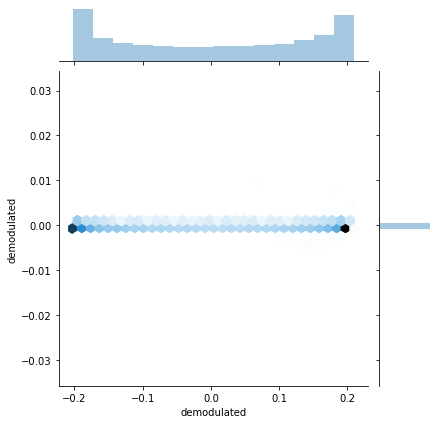

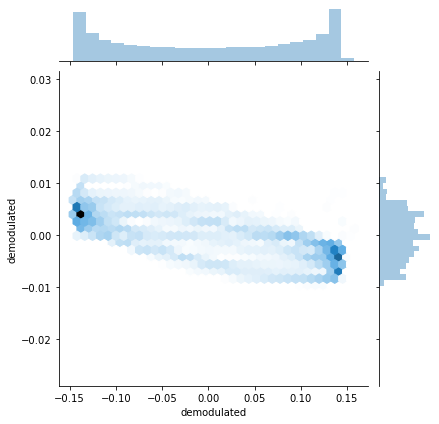

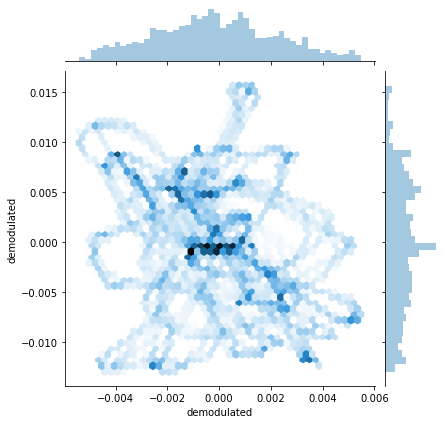

In [34]:
import seaborn as sns
sns.jointplot(x = ds['high_MS_coh_demodulated'].real,
              y=ds['high_MS_coh_demodulated'].imag,kind="hex")

sns.jointplot(x = ds['high_MS_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['high_MS_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds['high_MS_inc_demodulated'].real.mean('draw').sel(T=80),
              y=ds['high_MS_inc_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_coh'].demodulated.real.sel(bandwidth=0.4),
              y=ds_filtered['high_MS_coh'].demodulated.imag.sel(bandwidth=0.4),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_mix'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['high_MS_mix'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_inc'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['high_MS_inc'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

In [54]:
h_M2 = signal.hilbert(ds['M2_coh'].real)

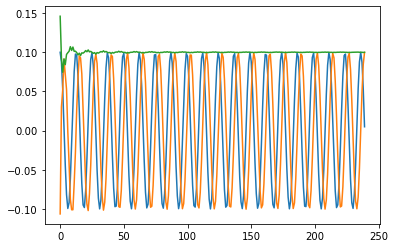

In [65]:
plt.plot(h_M2.real[0:int(10/dt)])
plt.plot(h_M2.imag[0:int(10/dt)])
plt.plot(np.abs(h_M2[0:int(10/dt)]))

In [74]:
h_M2_demod = h_M2*np.exp(-1j*rad*omega_M2*ds.time)

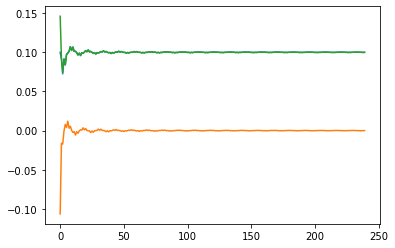

In [75]:
plt.plot(h_M2_demod.real[0:int(10/dt)])
plt.plot(h_M2_demod.imag[0:int(10/dt)])
plt.plot(np.abs(h_M2_demod[0:int(10/dt)]))

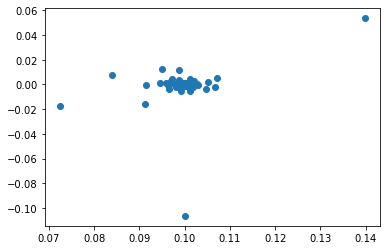

In [76]:
plt.scatter(np.real(h_M2_demod),np.imag(h_M2_demod))

AttributeError: 'JointGrid' object has no attribute 'figure'

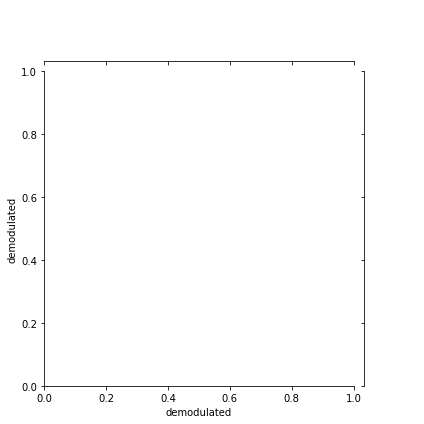

In [32]:


g = sns.JointGrid(x=ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4),
                  y=ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4))

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

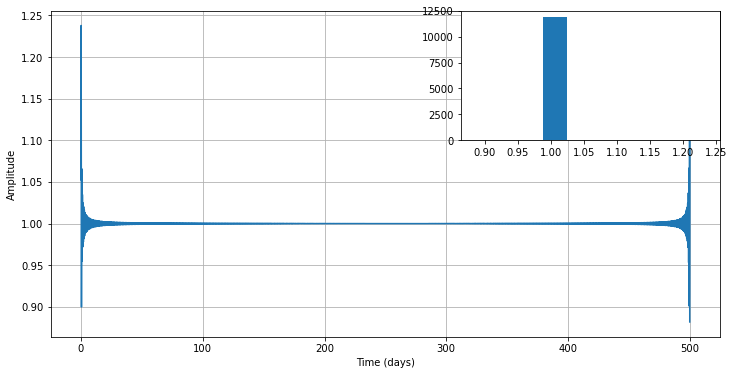

In [30]:
s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

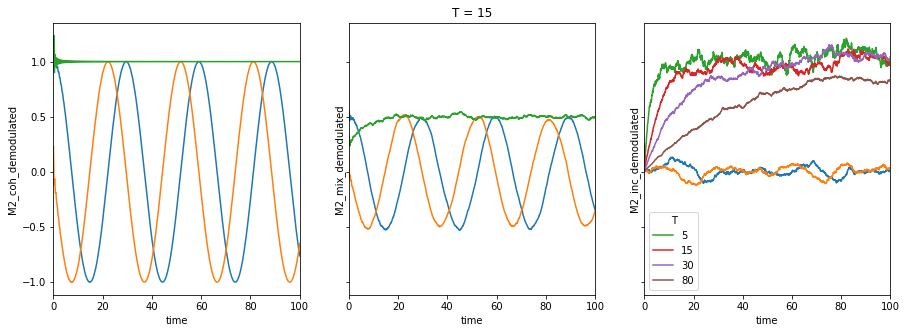

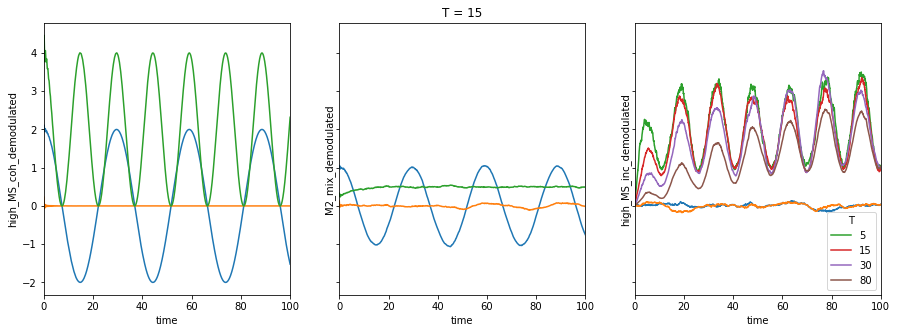

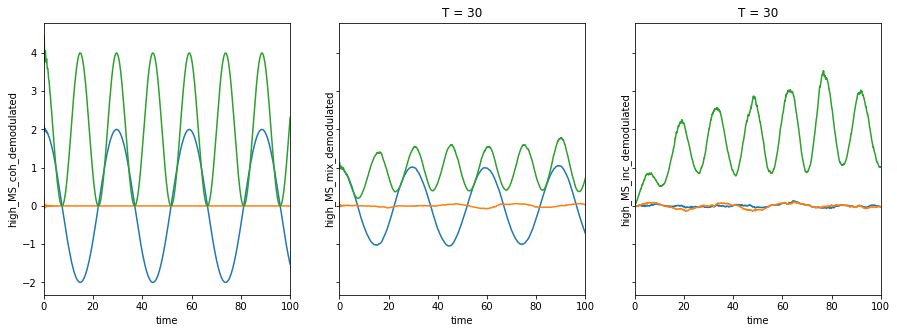

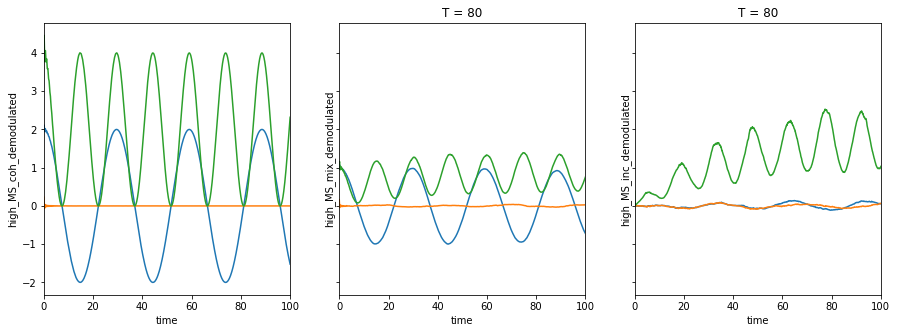

In [38]:
delta_T = 100
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.M2_coh_demodulated.real.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
ds.M2_coh_demodulated.imag.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.M2_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.M2_mix_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.M2_mix_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.M2_inc_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.M2_inc_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.M2_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))

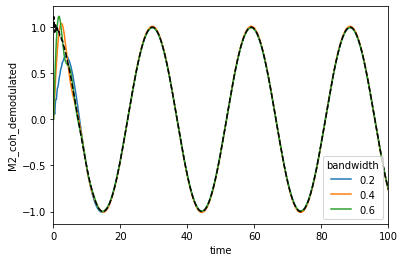

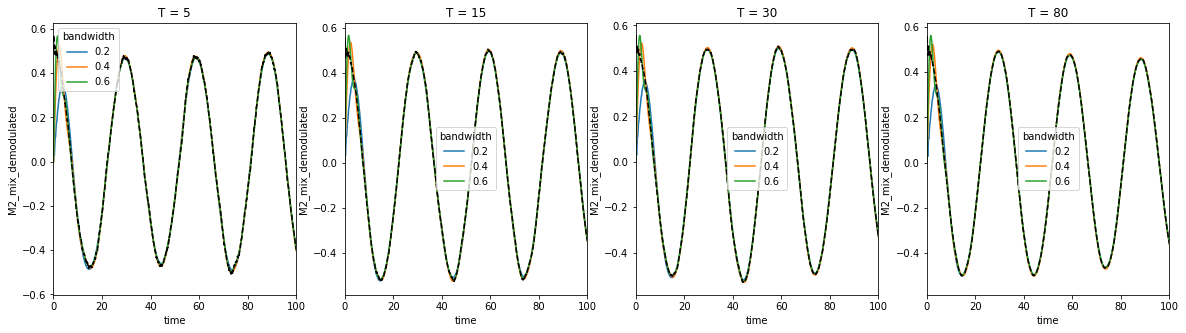

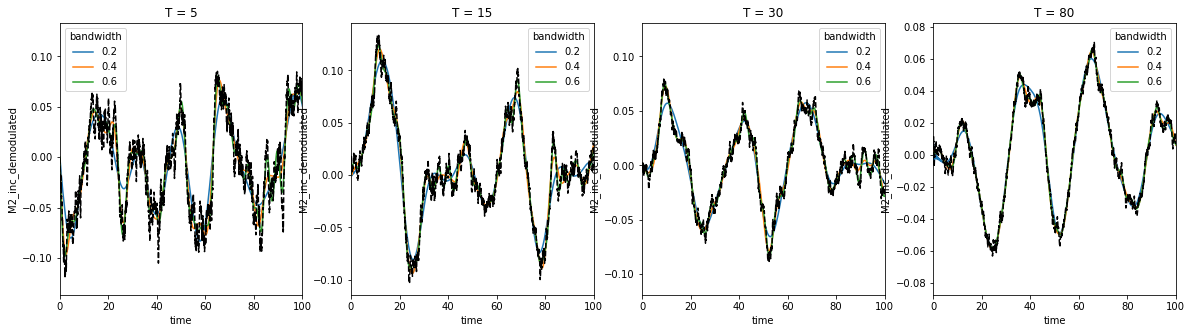

In [39]:
ds_filtered['M2_coh'].demodulated.mean('draw').real.plot(xlim=(0,delta_T),hue='bandwidth')
ds.M2_coh_demodulated.mean('draw').real.plot(c='k',linestyle='--',xlim=(0,delta_T))
fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_mix'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_mix_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_inc'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_inc_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

In [93]:
ds_filtered['M2_coh'].demodulated.real.mean('draw')

<xarray.DataArray 'demodulated' (bandwidth: 3, time: 12000)>
array([[ 7.54683545e-10,  9.43415838e-02,  1.28612472e-01, ...,
         9.88973021e-02,  5.79307074e-02, -1.99162802e-02],
       [ 3.09159729e-09,  6.47760742e-02,  9.87018960e-02, ...,
         8.10057289e-02,  3.69714191e-02, -1.61597619e-02],
       [ 7.08552519e-09,  5.83595948e-02,  1.00107718e-01, ...,
         8.63857223e-02,  3.38337468e-02, -1.44799908e-02]])
Coordinates:
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    exp        (time) complex128 (1+0j) ... (0.9963946710000068+0.08483902169...
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6

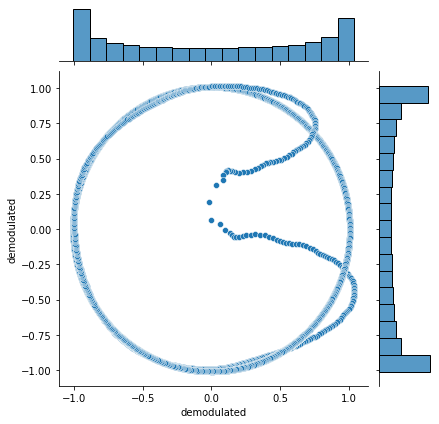

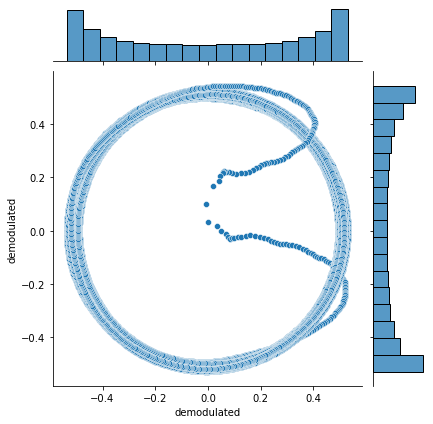

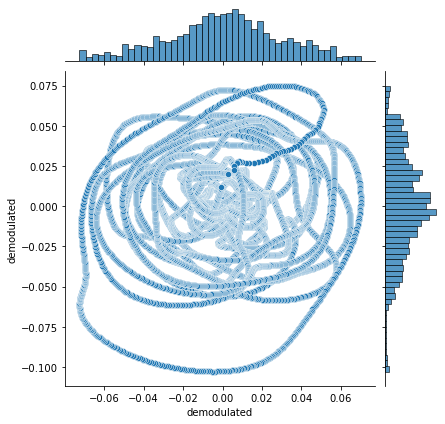

In [97]:
import seaborn as sns
sns.jointplot(x = ds_filtered['M2_coh'].demodulated.real.mean('draw').sel(bandwidth=0.4),y=ds_filtered['M2_coh'].demodulated.imag.mean('draw').sel(bandwidth=0.4),kind="scatter")

sns.jointplot(x = ds_filtered['M2_mix'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_mix'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

sns.jointplot(x = ds_filtered['M2_inc'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_inc'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

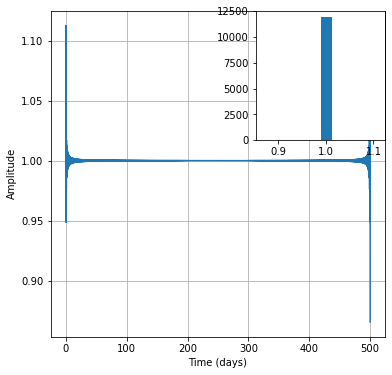

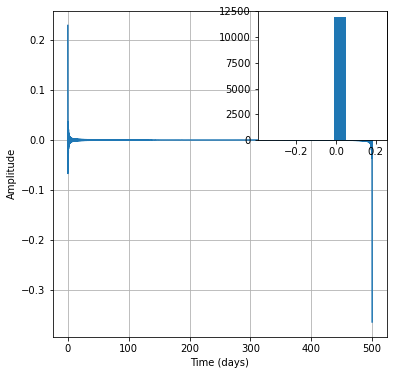

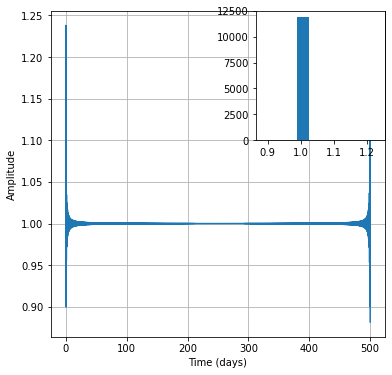

In [95]:
s = ds.M2_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.M2_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

(array([2611., 1164.,  956.,  879.,  858.,  881.,  961., 1156., 2525.,
           9.]),
 array([5.57766610e-08, 4.46081224e-01, 8.92162392e-01, 1.33824356e+00,
        1.78432473e+00, 2.23040590e+00, 2.67648706e+00, 3.12256823e+00,
        3.56864940e+00, 4.01473057e+00, 4.46081174e+00]),
 <BarContainer object of 10 artists>)

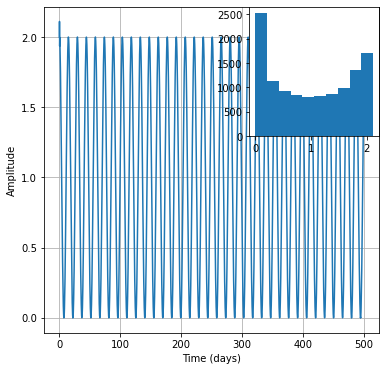

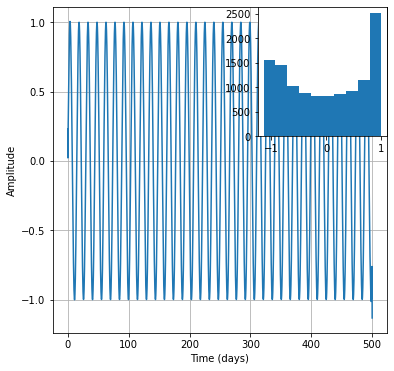

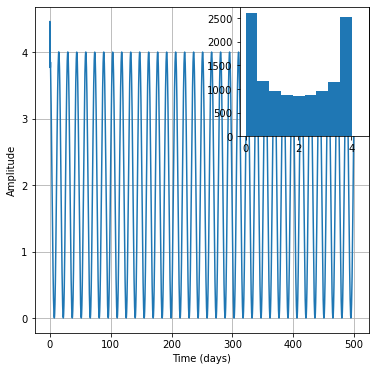

In [96]:
s = ds.high_MS_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.high_MS_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

In [81]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
